# Explorer Baseball Reference Data

__This workbook has two objectives:__

1) Use major leagues stats from an individual season in order to predict a player's salary for that season.

2) Use aggregated minor league stats in order to predict that player's highest paid major league season.

__Import useful packages__

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import ml_insights as mli
import copy

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

__Open all_batters.csv__

In [2]:
batters_df = pd.read_csv('all_batters.csv')

__Generate Historical Salary Data in order to account for salary inflation__

In [3]:
mlb_salary_data = [[1967, 6000, 19000], [1970, 12000, 29303], [1975, 16000, 44676],
 [1980, 30000, 143676], [1985, 60000, 371157], [1990, 100000, 597537],
 [1995, 109000, 1110766], [2000, 200000, 1895630], [2005, 316000, 2476589],
 [2010, 400000, 3014572], [2015, 507500, 3952252]]

salary_df = pd.DataFrame(mlb_salary_data,columns=['Year','min_salary','mean_salary'])
dummy = pd.DataFrame(np.arange(1967,2018),columns=['Year'])
salary_df = salary_df.merge(dummy,how = 'outer').sort_values('Year').set_index('Year')
salary_df = salary_df.interpolate().reset_index()

__Define some "helper functions"__



In [4]:
# Determine primary position, the number of positions played.
# Also add an indicator variable for each position.
def add_position_cols(df):
    
    new_df = df
    new_df['pos_count'] = df['Pos'].str.replace('[*/]', '').apply(str).apply(len)
    new_df['pos_primary'] = df['Pos'].str.replace('[*/]', '').apply(str).str[0]

    position_names = ['1','2','3','4','5','6','7','8','D']
    for p_name in position_names:
        new_df['Pos_'+ p_name] = df['Pos'].str.contains(p_name)

    new_df['pos_difficulty'] = new_df['pos_primary'] 
    
    #Map Positions by difficulty 0 being, easiest
    # Unlike wikipedia, I think that CF is harder than 2B
    pos_dict = {'D':0, '3':1, '7':2,'9':3,'5':4, '4':5,'8':6,'6':7,'2':8,'1':9,'n':np.nan}
    new_df['pos_difficulty'].replace(pos_dict, inplace=True)
    new_df['pos_difficulty'] = pd.to_numeric(new_df['pos_difficulty'])
        
    return new_df

# Calculate the number of seasons since the start of player's career.
# This will serve as a proxy for service time. There are many missing 
# values in the service time field from the salary data.
def add_season_number(df):
    first_year = pd.DataFrame()
    first_year['First_Year'] = df.groupby(['player_id']).min()['Year']
    first_year = first_year.reset_index()
    df = df.merge(first_year, how = 'outer')
    
    df['season_number'] = df['Year'] - df['First_Year'] + 1
    #df = df.drop('First_Year',axis = 1)
    return df

# Calculate the number of single from other hit data
def add_singles(df):
    df['1B'] = df['H'] - df['2B'] - df['3B'] - df['HR']
    return df

# Separate major and minor leagues stats into separate data frames
def separate_majors_minors(df):
    
    # Groupby should give only total year's stats
    maj_df = df.loc[df['Lg'].isin(['AL','NL','MLB'])].groupby(['player_id','Year']).first()
    maj_df = maj_df.reset_index()
    min_df = df.loc[-df['Lg'].isin(['AL','NL','MLB'])]
    return maj_df, min_df


# Aggregate year by year stats into full career data.
# Requires the recalculation of rate based stats from their definitions.
def make_career_stats(df):
    
    counting_stats = ['G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB',
       'CS', 'BB', 'SO','TB', 'GDP', 'HBP','SH', 'SF', 'IBB','Salary']
    
    # Will need this later
    df['weighted_OPS+'] = df['OPS+']*df['PA']
    
    # Make groupby object to only do aggregation once
    grouped_obj = df.groupby('player_id')
    df_grouped = grouped_obj.sum()[counting_stats]
    
    
    # Service Time is Cumulative but already calculated for me
    df_grouped['SrvTm'] = grouped_obj.max()['SrvTm']
    
    if 'normalized_salary' in df.columns:
        df_grouped['normalized_salary'] = grouped_obj.sum()['normalized_salary']
    
    ### Generate non "counting stats" ###
    
    ## Batting Average = Number of Hits (divided by) Number of At Bats
    df_grouped['BA'] = df_grouped['H']/df_grouped['AB']
    
    ## On Base Percentage
    # (Hits + Walks + Hit-By-Pitch) divided by (At Bats + Walks+ Hit-By-Pitch + Sac Flys)
    df_grouped['OBP'] = (df_grouped['H'] + df_grouped['BB'] + df_grouped['HBP']) \
        / (df_grouped['AB'] + df_grouped['BB'] + df_grouped['HBP']+df_grouped['SF']) 
        
    ## Slugging Percentage
    # Number of (Singles + [2 x Doubles] +[ 3 x Triples] + [4 x Home Runs]) divided by At Bats
    
    # Need to calculate singles first
    df_grouped['1B'] = df_grouped['H'] - df_grouped['2B'] - df_grouped['3B'] - df_grouped['HR']
    
    df_grouped['SLG'] = (df_grouped['1B'] + 2*df_grouped['2B'] 
                         + 3*df_grouped['3B'] + 4*df_grouped['HR']) / df_grouped['AB']
    
    # On Base Plus Slugging 
    df_grouped['OPS'] = df_grouped['OBP'] + df_grouped['SLG']
    
    ## OPS+ (Weighted Average)
    # Assuming that weighting year by year OPS+ by the number of PA is close enough
    df_grouped['OPS+'] = grouped_obj.sum()['weighted_OPS+']/grouped_obj.sum()['PA']
    
    df_grouped['BB_rate'] = df_grouped['BB']/df_grouped['PA']
    df_grouped['SO_rate'] = df_grouped['SO']/df_grouped['PA']
    df_grouped['HR_rate'] = df_grouped['HR']/df_grouped['PA']
    
    
    return df_grouped


__Clean up the data a bit__

Use Salary Data to create era adjusted salary values. 1 is equivalent to mean salary. >1  indicates being paid more than the average player.Normalization was done baseball salaries have inflated much faster than regular peoples' salaries

In [5]:
batters_df = pd.merge(left = batters_df,right = salary_df, on = 'Year' )
batters_df['normalized_salary'] = batters_df['Salary']/batters_df['mean_salary']

__Add other useful columns__

In [6]:
batters_df = add_position_cols(batters_df)
batters_df = add_singles(batters_df)

__Remove Pre-1990 data to prevent biasing those years to only have players with long careers__

In [7]:
min_year = 1990
max_year = 2016
bad_year = 1994 #Strike year, not full season

__Split data into majors and minors__

In [8]:
majors_df, minors_df = separate_majors_minors(batters_df)

majors_df = add_season_number(majors_df)
majors_df = majors_df.loc[majors_df['Year'] >= min_year]
majors_df = majors_df.loc[majors_df['Year'] <= max_year]
majors_df = majors_df.loc[majors_df['Year'] != bad_year]

# Remove Player Seasons with salary data
majors_df = majors_df.dropna(axis = 0, subset=['normalized_salary'])

#### Aggregate Careers

Find the __Highest paid season__ of Majors League player's who had a chance to reach free agency, based on their start date. __Note__, not all players will not have actually reached due to short careers, or frequently being sent down to the minors.

Exclued players who started in the major leagues after 2010, as they will not have had a chance to reach free agency by 2016.

In [9]:
majors_got_paid = majors_df[majors_df['First_Year']<2010].groupby(['player_id','normalized_salary']).max().reset_index()

__ Minors__

In [10]:
#minors_df = minors_df.loc[minors_df['Age'] < 26] # Get Rid of non Prospects/ rehab
minors_career_df = make_career_stats(minors_df)
minors_career_df = minors_career_df.drop(['Salary','normalized_salary'], 1)
minors_career_df = minors_career_df.reset_index()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Join minors salary with maximum major league salary
Used for predicting peak salary off of minor league stats

In [11]:
majors_got_paid_max = majors_got_paid.groupby(['player_id'])['normalized_salary'].max()
majors_got_paid_max = pd.DataFrame(majors_got_paid_max).reset_index()

minors_career_df = minors_career_df.merge(majors_got_paid_max, how = 'left')
minors_career_df = minors_career_df.dropna(axis = 0, subset=['normalized_salary'])



# Predict major league salary for a given season given stats for that season


### Start by plotting the data


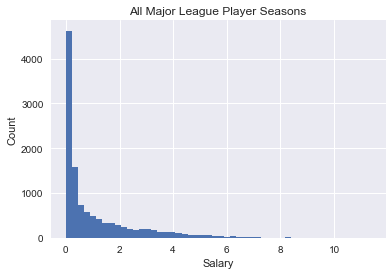

In [12]:
plt.hist(majors_df['normalized_salary'].dropna(how= 'any'),bins = 50);
plt.title('All Major League Player Seasons');
plt.xlabel('Salary');
plt.ylabel('Count');

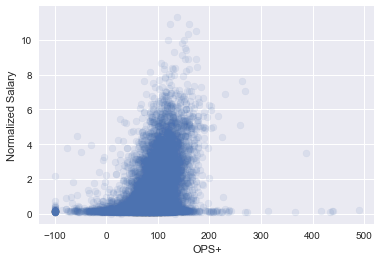

In [13]:
plt.scatter(majors_df['OPS+'],majors_df['normalized_salary'],alpha = 0.1)
plt.xlabel('OPS+')
plt.ylabel('Normalized Salary')

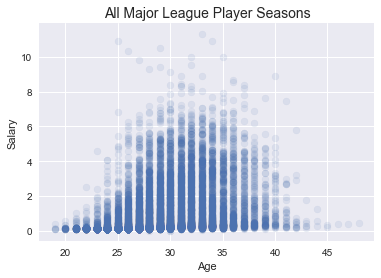

In [14]:
plt.scatter(majors_df['Age'],majors_df['normalized_salary'],alpha=0.1)
plt.title('All Major League Player Seasons',size =14);
plt.xlabel('Age');
plt.ylabel('Salary');

OPS: OBP + SLG 

Catch all stat, but not relative to peers

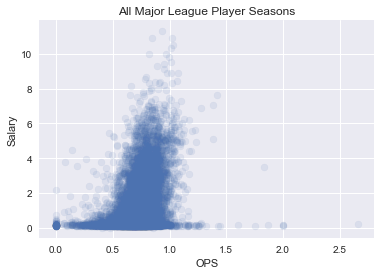

In [15]:
plt.scatter(majors_df['OPS'],majors_df['normalized_salary'],alpha = 0.1);
plt.title('All Major League Player Seasons');
plt.xlabel('OPS');
plt.ylabel('Salary');

Test to make sure my baseball inflation adjuster is working ok

<Container object of 26 artists>

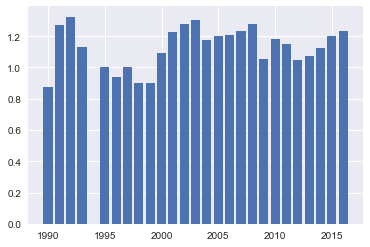

In [16]:
yearly_df = majors_df.groupby('Year').mean()
plt.bar(yearly_df.index, yearly_df['normalized_salary'])

See how many major leagures I have before filtering

In [17]:
len(majors_df)

11637

## Very Simple Model

AB = "At Bats" which is a measure of playing time

"OPS+" is a catch all statistic which measures hitting ability relative to peers.

In [18]:
majors_df_reduced1 = majors_df[['Age','AB','OPS+','normalized_salary']]

# 200 AB is a reasonable cut off for when stats start to stabilize
majors_df_reduced1 = majors_df_reduced1[majors_df_reduced1['AB'] >= 200]
majors_df_reduced1.dropna(how = 'any', inplace = True)

X_all1 = majors_df_reduced1.iloc[:, majors_df_reduced1.columns != 'normalized_salary']
y_all1 = majors_df_reduced1['normalized_salary']

__Fit Linear Model__

In [19]:
lr_model1 = LinearRegression()

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_all1, y_all1, test_size=0.3,random_state=31)
lr_model1.fit(X_train1, y_train1)

X_test1

,Age,AB,OPS+
17280,28.0,222.0,96.0
13446,26.0,487.0,115.0
2488,22.0,545.0,88.0
2506,27.0,548.0,178.0
7542,28.0,488.0,100.0
3219,32.0,599.0,109.0
9159,28.0,565.0,120.0
13142,25.0,259.0,101.0
3545,21.0,475.0,82.0
13578,27.0,379.0,91.0


R2 of 0.35 and RMSE of 1.3 (~6.5 million 2017 USD). Not great, but there is some predictive power in there.

In [20]:
predicted_normalized_salaries1 = lr_model1.predict(X_test1)
print(lr_model1.score(X_test1,y_test1))
print(np.sqrt(np.mean((predicted_normalized_salaries1 - y_test1)**2)))

0.345154879958
1.30995345699


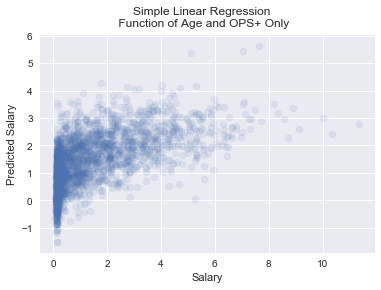

In [21]:
plt.scatter(y_test1,predicted_normalized_salaries1,alpha = 0.1)

plt.ylabel('Predicted Salary')
plt.xlabel('Salary')
plt.suptitle('Simple Linear Regression\n Function of Age and OPS+ Only')
plt.show()

## LASSO

Let's see if using a more complicated linear regression model, with more predictors can improve the model.

Sandbox for experimenting with predictors

In [22]:

## Counting stats only.  Statistics that are not used in the calcuation of eachother
## (Except HR and RBI)
# keep_cols = ['season_number', 'AB', 'R', '1B', '2B', '3B', 'HR', 'RBI', 'SB', \
#             'CS', 'BB', 'SO', 'GDP', 'HBP', 'IBB','pos_difficulty','normalized_salary']

## Add in rate based stats, SLG and OPS. Stats that are not dependent on at number of 
## plate appearances.
# keep_cols = ['season_number', 'AB', 'R', 'BA', 'H','SLG', 'OPS', 'HR', 'RBI', 'SB', \
#              'BB', 'SO', 'IBB', 'pos_difficulty', 'normalized_salary']


## Add positions as indicator variables with rate based stats
keep_cols = ['season_number', 'AB', 'R','1B', '2B', '3B', 'HR', 'RBI', 'SB', \
             'SLG','OPS','CS', 'BB', 'SO', 'GDP', 'HBP', 'IBB','normalized_salary',\
             'Pos_2', 'Pos_3', 'Pos_4','Pos_5','Pos_6','Pos_7','Pos_8','Pos_D']

## Add positions as indicator variables without rate based stats.
## Removing CS and GDP because those wouldn't intuitively be that useful
# keep_cols = ['season_number', 'AB', 'R','1B', '2B', '3B', 'HR', 'RBI', 'SB', \
#              'BB', 'SO', 'HBP', 'IBB','normalized_salary',\
#             'Pos_2', 'Pos_3', 'Pos_4','Pos_5','Pos_6','Pos_7','Pos_8','Pos_D']


# keep_cols = ['season_number', 'AB', 'R','1B', '2B', '3B', 'HR', 'RBI', 'SB', \
#        'CS', 'BB', 'SO', 'GDP', 'HBP', 'IBB','normalized_salary',\
#        'Pos_2', 'Pos_3', 'Pos_4','Pos_5','Pos_6','Pos_7','Pos_8','Pos_D',\
#        'HR_rate','BB_rate', 'SO_rate']

# keep_cols = ['Age', 'AB', 'R','1B', '2B', '3B', 'HR', 'RBI', 'SB', \
#        'CS', 'BB', 'SO', 'GDP', 'HBP', 'IBB','normalized_salary',\
#         'Pos_2', 'Pos_3', 'Pos_4','Pos_5','Pos_6','Pos_7','Pos_8','Pos_D']


# keep_cols = ['season_number', 'AB', 'R', 'H','SLG','OPS', 'HR', 'RBI', 'SB', \
#        'CS', 'BB', 'SO', 'GDP', 'HBP', 'IBB','normalized_salary']


## Filtering out people making close to the minimum
# majors_df_reduced2 = majors_df[(majors_df['Salary'] >= 1.5*majors_df['min_salary']) 
#               & (majors_df['AB']>200)][keep_cols].dropna(axis=0,how = 'any')

## Filter out player season that are very short. 
# Too small of sample sizes are not indicative of performance 
# http://www.fangraphs.com/library/principles/sample-size/
majors_df_reduced2 = majors_df[keep_cols].dropna(axis=0,how = 'any')
majors_df_reduced2 = majors_df_reduced2.loc[(majors_df_reduced2['AB']>200)]

#majors_df_reduced2 = shuffle(majors_df_reduced2)

# majors_df_reduced2 = majors_df.loc[(majors_df['AB']>300) 
#                                              & (majors_df['season_number']> 6)][keep_cols].dropna(axis=0,how = 'any')


X_all2 = majors_df_reduced2.iloc[:, majors_df_reduced2.columns != 'normalized_salary']
y_all2 = majors_df_reduced2['normalized_salary']

#X_train2, X_test2, y_train2, y_test2 = train_test_split(X_all2, y_all2, test_size=0.3)

__Avoid Shuffling data__

Ordering alphabetically. This prevents leakage of players from training set to test set.

However, this means that the same player may appear in either the training set, or test set multiple times. I think this is okay, because as players age they will have different skill sets.

In [23]:
split_ind = int(np.shape(X_all2)[0]*.2)
X_train2 = X_all2.iloc[:split_ind,:]
X_test2 = X_all2.iloc[split_ind:,:]
y_train2 = y_all2[:split_ind]
y_test2 = y_all2[split_ind:]

Put all of the features on the same scale such that coefficient size will be indicative of variable importance.

Start with a generic penalty term (alpha).

In [24]:
std = StandardScaler()
#std.fit(X_train.values.astype(float))
std.fit(X_train2)

X_tr2 = std.transform(X_train2)
X_te2 = std.transform(X_test2)
lr_model2 = Lasso(alpha = .1)
lr_model2.fit(X_tr2,y_train2)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [25]:
len(y_all2)

7819

Season number is very important. Makes sense given mlb salary structures.

IBB importance is very interesting. It's not a skill per say, and more a reflection of how good the other team thinks a player is.

In [26]:
list(zip(X_train2.columns,lr_model2.coef_))

[('season_number', 0.63941458500272585),
 ('AB', 0.0),
 ('R', 0.071971861492046069),
 ('1B', 0.0),
 ('2B', 0.0),
 ('3B', -0.0),
 ('HR', 0.069919430876287977),
 ('RBI', 0.22204772474616438),
 ('SB', 0.0),
 ('SLG', 0.0),
 ('OPS', 0.0),
 ('CS', 0.0),
 ('BB', 0.20082408864883008),
 ('SO', -0.0),
 ('GDP', 0.015871703362698199),
 ('HBP', 0.0),
 ('IBB', 0.19886941421487267),
 ('Pos_2', -0.0),
 ('Pos_3', -0.0),
 ('Pos_4', -0.0),
 ('Pos_5', -0.043061030190444563),
 ('Pos_6', -0.017609833967704065),
 ('Pos_7', -0.0),
 ('Pos_8', -0.0),
 ('Pos_D', 0.0)]

Slight improvement compared to simpliest model.

In [27]:
test_set_pred2 = lr_model2.predict(X_te2)
print(lr_model2.score(X_te2,y_test2))
print(np.sqrt(np.mean((test_set_pred2 - y_test2)**2)))

0.446544571214
1.21030317489


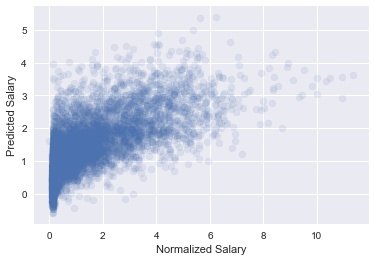

In [28]:
plt.scatter(y_test2,test_set_pred2,alpha = 0.1)
plt.xlabel('Normalized Salary')
plt.ylabel('Predicted Salary')
plt.show()

## Lets Try Lasso CV

Same methodology as before. However, try a range of alphas to see which best fits the data.

Apparently everything is important other than AB and slugging percentage (I'm not buying that).

In [29]:
alphavec = 10**np.linspace(-3,2,100)
#alphMavec

# Can use the same slicing of the data as before
lr_model3 = LassoCV(alphas = alphavec, cv=5)
lr_model3.fit(X_tr2,y_train2)
lr_model3.alpha_

list(zip(X_train2.columns,lr_model3.coef_))

[('season_number', 0.66897917151911612),
 ('AB', -0.0),
 ('R', 0.12645805762694606),
 ('1B', -0.057899584437901976),
 ('2B', -0.014430244014173138),
 ('3B', -0.026068099062243177),
 ('HR', 0.25373143004910803),
 ('RBI', 0.23239695035141603),
 ('SB', 0.10153695640878323),
 ('SLG', -0.0),
 ('OPS', -0.20313560189228527),
 ('CS', 0.0045757668239264073),
 ('BB', 0.26440282581514396),
 ('SO', -0.18625925036865323),
 ('GDP', 0.08176913079955149),
 ('HBP', -0.0032761742106337611),
 ('IBB', 0.23755962883385426),
 ('Pos_2', -0.12252538090664115),
 ('Pos_3', -0.024578234331809001),
 ('Pos_4', -0.042121800359743423),
 ('Pos_5', -0.1241408505313273),
 ('Pos_6', -0.10714125893382635),
 ('Pos_7', -0.081367330046767647),
 ('Pos_8', -0.04338986304765776),
 ('Pos_D', 0.042185505623961436)]

Lasso CV Just chose almost all of the features

In [30]:
pred3 = lr_model3.predict(X_te2)
lr_model3.score(X_te2,y_test2)

0.46882240958348809

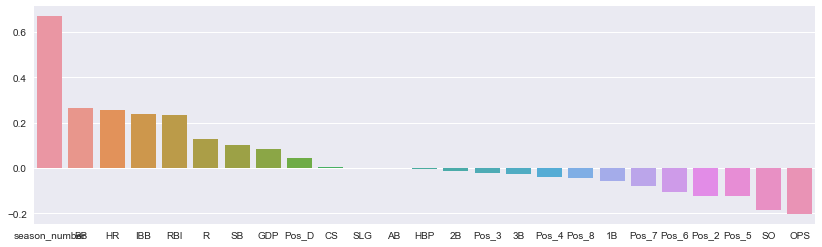

In [31]:
plt.figure(figsize=(14, 4))
lm3_feature_importance = pd.Series(lr_model3.coef_,index=X_test2.columns)
lm3_feature_importance.sort_values(ascending=False,inplace=True)
sns.barplot(lm3_feature_importance.index,lm3_feature_importance.values)
plt.show()

In [32]:
from sklearn import tree

dtrmodel = tree.DecisionTreeRegressor(min_samples_split=10, max_depth=6, min_samples_leaf=8)
dtrmodel.fit(X_train2,y_train2)
tree.export_graphviz(dtrmodel, out_file='tree.dot',feature_names = X_train2.columns)

## Lets Try Random Forest

#### Initialize the model, then fit it on the training data

In [33]:
rfmodel1 = ensemble.RandomForestRegressor(n_estimators = 1000, 
                                          min_samples_leaf= 6, 
                                          max_features=6,
                                          n_jobs=-1)
rfmodel1.fit(X_train2,y_train2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=6, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [34]:
rf1_test_pred = rfmodel1.predict(X_test2)

In [35]:
print(rfmodel1.score(X_test2,y_test2))

list(zip(X_test2.columns,rfmodel1.feature_importances_))

0.530730873547


[('season_number', 0.34051740650036255),
 ('AB', 0.034989615299741823),
 ('R', 0.06332184061071508),
 ('1B', 0.020394939143858221),
 ('2B', 0.019754105334945374),
 ('3B', 0.0087275810670396636),
 ('HR', 0.061388095138806512),
 ('RBI', 0.092937567847121358),
 ('SB', 0.014111282989933542),
 ('SLG', 0.034888331670729932),
 ('OPS', 0.061690724766515957),
 ('CS', 0.0087925959839182111),
 ('BB', 0.086462920332817966),
 ('SO', 0.021808860421298985),
 ('GDP', 0.015513932834518169),
 ('HBP', 0.0094031206955358833),
 ('IBB', 0.069124637121372484),
 ('Pos_2', 0.0012448625430418409),
 ('Pos_3', 0.003696407419763445),
 ('Pos_4', 0.0067505267414324785),
 ('Pos_5', 0.004393531095974435),
 ('Pos_6', 0.0062696073614426527),
 ('Pos_7', 0.0030605320468704701),
 ('Pos_8', 0.0019738039798768135),
 ('Pos_D', 0.0087831710523657517)]

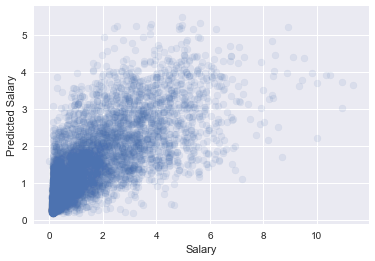

In [36]:
plt.scatter(y_test2,rf1_test_pred,alpha=0.1)
#plt.show()
plt.xlabel('Salary')
plt.ylabel('Predicted Salary')

In [37]:
print(rfmodel1.score(X_test2,y_test2))
print(np.sqrt(np.mean((rf1_test_pred - y_test2)**2)))

0.530730873547
1.11445833841


The more complicated model is fitting the data better than the simplier model. I'm guessing this is because Random Forest can model non-linear interactions.

Once again, the more sophisticated model illustrates that season number is massively important. It also suggests that player positin isn't a very strong predictor of salary.

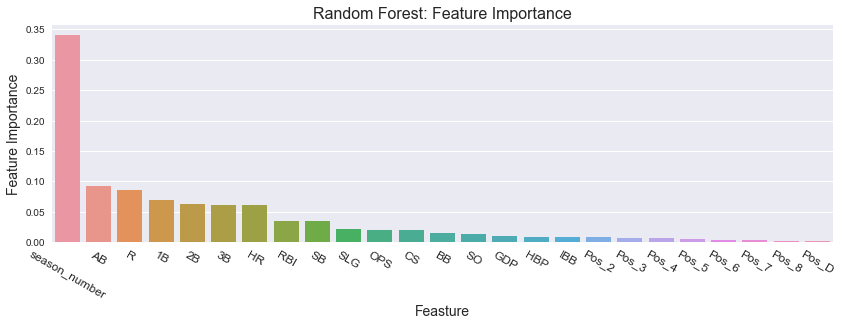

In [38]:
plt.figure(figsize=(14, 4))
rf1_feature_importance = pd.Series(rfmodel1.feature_importances_,index=X_test2.columns)
rf1_feature_importance.sort_values(ascending=False,inplace=True)
g = sns.barplot(rf1_feature_importance.index,rf1_feature_importance.values);
g.set_xticklabels(X_test2.columns, rotation=-30,size=12)
plt.ylabel('Feature Importance',size=14);
plt.xlabel('Feasture',size=14);
plt.title('Random Forest: Feature Importance',size = 16);

In [39]:
#mxr = mli.ModelXRay(rfmodel1,X_test2)

#indices = mxr.feature_dependence_plots(num_pt#s=7)

# Random Forest Optimized Using Grid Search

In [40]:
# parameters = {'min_samples_split':[5,10,15],
#               'min_samples_leaf':[3,5,10,15],
#               'n_estimators':[1000]}


parameters = {'min_samples_split':[4,6,8],
              'min_samples_leaf':[4,6,8],
              'n_estimators':[1000]}


rf_model2 = ensemble.RandomForestRegressor()
grid_search1 = GridSearchCV(rf_model2, parameters, n_jobs=-1, verbose=1)
grid_search1.fit(X_train2,y_train2)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [4, 6, 8], 'min_samples_leaf': [4, 6, 8], 'n_estimators': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [41]:
grid_search1.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=8,
           min_samples_split=6, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [42]:
rfgs1_test_pred = grid_search1.best_estimator_.predict(X_test2)
print(grid_search1.best_estimator_.score(X_test2,y_test2))
print(np.sqrt(np.mean((rfgs1_test_pred  - y_test2)**2)))

0.551252813825
1.08981734555


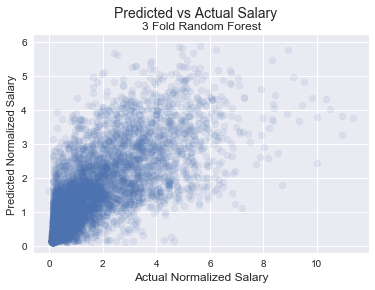

In [43]:
plt.scatter(y_test2,rfgs1_test_pred,alpha=0.1)
plt.suptitle('Predicted vs Actual Salary',size = 14)
plt.title('3 Fold Random Forest',size = 12)
plt.xlabel('Actual Normalized Salary',size = 12)
plt.ylabel('Predicted Normalized Salary')
plt.show()

In [44]:
list(zip(X_test2.columns,grid_search1.best_estimator_.feature_importances_))

[('season_number', 0.46022923639003094),
 ('AB', 0.024413513011411685),
 ('R', 0.11961889606732772),
 ('1B', 0.011900952994357256),
 ('2B', 0.0086716989978735531),
 ('3B', 0.0038448095065774434),
 ('HR', 0.023140822803102593),
 ('RBI', 0.09331699318544813),
 ('SB', 0.014814986554653858),
 ('SLG', 0.013921895586352002),
 ('OPS', 0.027354013840076834),
 ('CS', 0.0052310678403124644),
 ('BB', 0.046560980370641138),
 ('SO', 0.013336533978254623),
 ('GDP', 0.0089481636254842203),
 ('HBP', 0.0061137566513399149),
 ('IBB', 0.087609823395342276),
 ('Pos_2', 0.0019699365289567606),
 ('Pos_3', 0.0034005483824304534),
 ('Pos_4', 0.010815834285788486),
 ('Pos_5', 0.0032202520406659327),
 ('Pos_6', 0.0044483508749323308),
 ('Pos_7', 0.0019384575206790261),
 ('Pos_8', 0.0010730558613697794),
 ('Pos_D', 0.0041054197065904909)]

The "optimized" random forest model performed similarly to my best try (but a little better). Interestingly, in this model, total AB is significantly less important

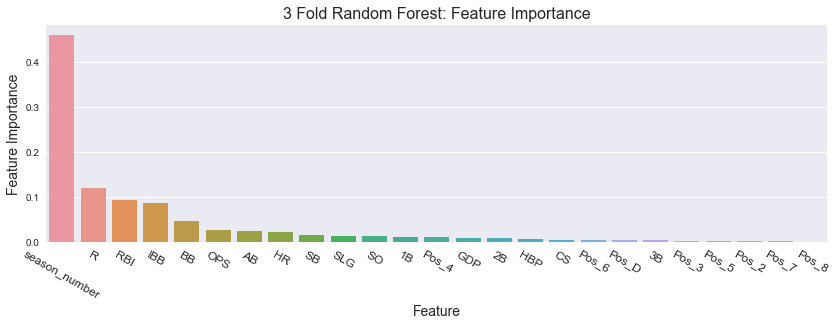

In [45]:
plt.figure(figsize=(14, 4))
gsrf1_feature_importance = pd.Series(grid_search1.best_estimator_.feature_importances_,index=X_test2.columns)
gsrf1_feature_importance.sort_values(ascending=False,inplace=True)
g = sns.barplot(gsrf1_feature_importance.index, gsrf1_feature_importance.values);
g.set_xticklabels(gsrf1_feature_importance.index, rotation=-30,size=12)
plt.ylabel('Feature Importance',size=14);
plt.xlabel('Feature',size=14);
plt.title('3 Fold Random Forest: Feature Importance',size = 16);

Looks like the model predicted that excellent seasons should be paid the highest. Model does not include a field for performance enhancing drugs.

In [47]:
combo_rf = copy.deepcopy(X_test2)
combo_rf['pred_salary'] = rfgs1_test_pred
combo_rf.sort_values('pred_salary',ascending=False).head(20)

,season_number,AB,R,1B,2B,3B,HR,RBI,SB,SLG,OPS,CS,BB,SO,GDP,HBP,IBB,Pos_2,Pos_3,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_D,pred_salary
11069,13.0,509.0,130.0,61.0,21.0,0.0,70.0,147.0,1.0,0.752,1.222,0.0,162.0,155.0,8.0,6.0,28.0,False,True,False,False,False,False,False,False,5.879
13739,10.0,587.0,115.0,101.0,39.0,1.0,42.0,118.0,14.0,0.596,1.011,4.0,103.0,76.0,23.0,4.0,38.0,False,True,False,False,False,False,False,False,5.837
13738,9.0,568.0,124.0,93.0,45.0,1.0,47.0,135.0,16.0,0.658,1.101,4.0,115.0,64.0,23.0,9.0,44.0,False,True,False,False,False,False,False,True,5.804
13958,11.0,569.0,117.0,111.0,36.0,1.0,37.0,104.0,3.0,0.587,1.014,1.0,97.0,94.0,22.0,8.0,28.0,False,False,False,False,False,True,False,True,5.762
15956,13.0,577.0,146.0,86.0,34.0,5.0,64.0,160.0,0.0,0.737,1.174,2.0,116.0,153.0,6.0,6.0,37.0,False,False,False,False,False,False,False,False,5.755
11070,14.0,521.0,118.0,58.0,21.0,1.0,65.0,147.0,0.0,0.697,1.120,0.0,133.0,141.0,12.0,2.0,21.0,False,True,False,False,False,False,False,False,5.663
6347,12.0,609.0,128.0,98.0,36.0,7.0,57.0,142.0,1.0,0.688,1.117,1.0,100.0,83.0,14.0,14.0,24.0,False,False,False,False,False,True,False,False,5.661
12555,10.0,558.0,115.0,75.0,29.0,2.0,54.0,137.0,1.0,0.636,1.049,0.0,119.0,117.0,12.0,4.0,23.0,False,True,False,False,False,False,False,True,5.601
13737,8.0,524.0,100.0,106.0,44.0,0.0,37.0,116.0,7.0,0.653,1.114,3.0,104.0,54.0,16.0,5.0,34.0,False,True,True,False,False,False,False,True,5.596
16731,14.0,508.0,97.0,68.0,28.0,1.0,42.0,105.0,0.0,0.581,0.977,2.0,104.0,144.0,10.0,2.0,26.0,False,True,False,False,False,False,False,True,5.471


# Gradient Boosted Trees

Let's throw the kitchen sink at this problem and see if an even more complicated model can do better.

In [48]:
parameters = {'subsample':np.arange(.6,.8,.1),
              'max_depth':[3,5,10],
              'learning_rate':[0.01],
              'n_estimators':[1000]}

model = ensemble.GradientBoostingRegressor()
grid_search2 = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)
grid_search2.fit(X_train2,y_train2)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   51.7s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'subsample': array([ 0.6,  0.7,  0.8]), 'max_depth': [3, 5, 10], 'learning_rate': [0.01], 'n_estimators': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [49]:
list(zip(X_test2.columns, grid_search2.best_estimator_.feature_importances_))

[('season_number', 0.1857125839042294),
 ('AB', 0.056429669704701757),
 ('R', 0.052794318970069552),
 ('1B', 0.037630317281445481),
 ('2B', 0.027287781989194286),
 ('3B', 0.014317614829146478),
 ('HR', 0.05336110542523087),
 ('RBI', 0.061046946458000843),
 ('SB', 0.035036675622103726),
 ('SLG', 0.052355173215951942),
 ('OPS', 0.063492644847300592),
 ('CS', 0.021668045309469534),
 ('BB', 0.062209292885409259),
 ('SO', 0.057894624434452958),
 ('GDP', 0.037198609345323867),
 ('HBP', 0.030428731069492437),
 ('IBB', 0.073961874593278146),
 ('Pos_2', 0.0090385098412635485),
 ('Pos_3', 0.0067333639940650048),
 ('Pos_4', 0.0065687039826534876),
 ('Pos_5', 0.016033361096735241),
 ('Pos_6', 0.015008380341736042),
 ('Pos_7', 0.0084697538545745223),
 ('Pos_8', 0.0057249997613703779),
 ('Pos_D', 0.0095969172428008939)]

Slightly better than RF, but not by much.

In [50]:
grbst_test_pred = grid_search2.best_estimator_.predict(X_test2)
print(grid_search2.best_estimator_.score(X_test2,y_test2))
print(np.sqrt(np.mean((grbst_test_pred  - y_test2)**2)))

0.551303715015
1.08975553505


Gradient boosted trees likes Albert Pujol's second MVP season. Not bad.

In [51]:
combo_grbst = X_test2
combo_grbst['pred_salary'] = grbst_test_pred 
combo_grbst.sort_values('pred_salary',ascending=False)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,season_number,AB,R,1B,2B,3B,HR,RBI,SB,SLG,OPS,CS,BB,SO,GDP,HBP,IBB,Pos_2,Pos_3,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_D,pred_salary
13738,9.0,568.0,124.0,93.0,45.0,1.0,47.0,135.0,16.0,0.658,1.101,4.0,115.0,64.0,23.0,9.0,44.0,False,True,False,False,False,False,False,True,6.483
6564,10.0,582.0,110.0,92.0,31.0,1.0,42.0,114.0,8.0,0.558,0.944,5.0,93.0,112.0,26.0,5.0,22.0,False,False,False,False,False,False,False,True,6.476
13958,11.0,569.0,117.0,111.0,36.0,1.0,37.0,104.0,3.0,0.587,1.014,1.0,97.0,94.0,22.0,8.0,28.0,False,False,False,False,False,True,False,True,6.342
13739,10.0,587.0,115.0,101.0,39.0,1.0,42.0,118.0,14.0,0.596,1.011,4.0,103.0,76.0,23.0,4.0,38.0,False,True,False,False,False,False,False,False,6.334
6253,8.0,630.0,108.0,138.0,45.0,3.0,27.0,117.0,1.0,0.548,0.957,0.0,74.0,119.0,28.0,6.0,20.0,False,True,False,False,False,False,False,True,5.954
13737,8.0,524.0,100.0,106.0,44.0,0.0,37.0,116.0,7.0,0.653,1.114,3.0,104.0,54.0,16.0,5.0,34.0,False,True,True,False,False,False,False,True,5.933
12757,11.0,626.0,110.0,100.0,40.0,2.0,39.0,142.0,8.0,0.546,0.927,0.0,95.0,96.0,9.0,3.0,12.0,False,True,False,False,False,False,False,True,5.828
6347,12.0,609.0,128.0,98.0,36.0,7.0,57.0,142.0,1.0,0.688,1.117,1.0,100.0,83.0,14.0,14.0,24.0,False,False,False,False,False,True,False,False,5.690
10701,13.0,561.0,87.0,123.0,33.0,0.0,32.0,103.0,3.0,0.565,0.974,2.0,70.0,42.0,17.0,4.0,28.0,True,True,False,False,False,False,False,True,5.594
12555,10.0,558.0,115.0,75.0,29.0,2.0,54.0,137.0,1.0,0.636,1.049,0.0,119.0,117.0,12.0,4.0,23.0,False,True,False,False,False,False,False,True,5.548


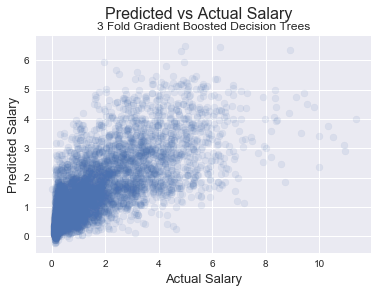

In [52]:
plt.scatter(y_test2,grbst_test_pred,alpha=0.1)
plt.ylabel('Predicted Salary',size=13);
plt.xlabel('Actual Salary',size=13);
plt.suptitle('Predicted vs Actual Salary',size = 16);
plt.title('3 Fold Gradient Boosted Decision Trees',size = 12);

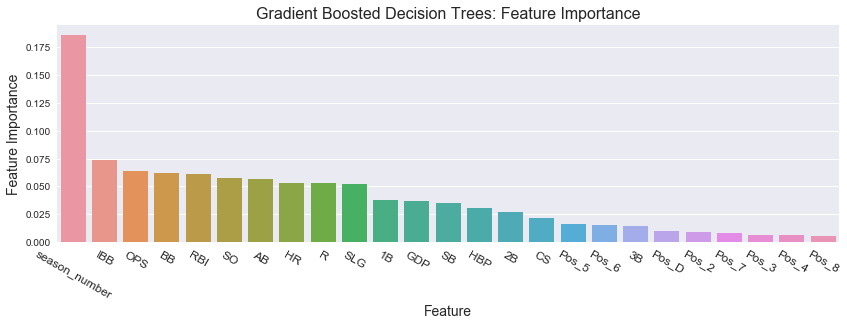

In [53]:
plt.figure(figsize=(14, 4))
gsbt1_feature_importance = pd.Series(grid_search2.best_estimator_.feature_importances_, index=X_test2.columns[:-1])
gsbt1_feature_importance.sort_values(ascending=False,inplace=True)
g = sns.barplot(gsbt1_feature_importance.index, gsbt1_feature_importance);
g.set_xticklabels(gsbt1_feature_importance.index, rotation=-30,size=12)
plt.ylabel('Feature Importance',size=14);
plt.xlabel('Feature',size=14);
plt.title('Gradient Boosted Decision Trees: Feature Importance',size = 16);

# Minor League Data to Predict Peak Salary

Position data not available for minor leaguers

In [54]:
# keep_cols = ['AB', 'R', '1B', '2B', '3B', 'HR', 'RBI', 'SB', \
#              'CS', 'BB', 'SO', 'GDP', 'HBP', 'IBB','normalized_salary']

keep_cols = ['player_id','AB', 'R', 'BA', 'H','SLG', 'OBP', 'HR','HR_rate', 'RBI', 'SB', \
             'BB_rate', 'SO_rate', 'IBB', 'normalized_salary']


# keep_cols = ['AB','SLG', 'OPS', 'SB', \
#              'BB', 'SO', 'IBB', 'normalized_salary']

# keep_cols = ['AB','SLG', 'OPS', 'SB', \
#              'BB_rate', 'SO_rate', 'IBB', 'normalized_salary']

# keep_cols = ['player_id', 'AB', 'R','1B', '2B', '3B', 'HR', 'RBI', 'SB', \
#              'SLG', 'OPS','CS', 'BB', 'SO', 'GDP', 'HBP', 'IBB','normalized_salary']

# keep_cols = ['season_number', 'AB', 'R', 'H','SLG','OPS', 'HR', 'RBI', 'SB', \
#        'CS', 'BB', 'SO', 'GDP', 'HBP', 'IBB','normalized_salary']

# Try and then try adding postions


# Filtering out people making close to the minimum
# majors_df_reduced2 = majors_df[(majors_df['Salary'] >= 1.5*majors_df['min_salary']) 
#               & (majors_df['AB']>200)][keep_cols].dropna(axis=0,how = 'any')
minors_career_reduced = minors_career_df[keep_cols].dropna(axis=0,how = 'any')
#minors_career_reduced = minors_career_reduced.loc[(minors_career_df['AB']>200)]

# majors_df_reduced2 = majors_df.loc[(majors_df['AB']>300) 
#                                              & (majors_df['season_number']> 6)][keep_cols].dropna(axis=0,how = 'any')


X_all3 = minors_career_reduced.iloc[:,minors_career_reduced.columns != 'normalized_salary']
y_all3 = minors_career_reduced['normalized_salary']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_all3, y_all3, test_size=0.3)
X_train3.iloc[:,1:]

,AB,R,BA,H,SLG,OBP,HR,HR_rate,RBI,SB,BB_rate,SO_rate,IBB
852,3040.0,423.0,0.263,800.0,0.423,0.354,93.0,0.027,483.0,20.0,0.117,0.203,39.0
1599,2022.0,350.0,0.340,688.0,0.530,0.411,63.0,0.027,430.0,27.0,0.105,0.145,18.0
467,2854.0,374.0,0.276,789.0,0.445,0.339,96.0,0.030,425.0,32.0,0.078,0.193,7.0
1240,3823.0,677.0,0.285,1089.0,0.480,0.384,152.0,0.034,596.0,78.0,0.122,0.239,26.0
792,5365.0,782.0,0.273,1464.0,0.398,0.324,90.0,0.015,570.0,291.0,0.059,0.245,5.0
1303,2574.0,385.0,0.292,751.0,0.451,0.375,61.0,0.021,377.0,34.0,0.118,0.150,38.0
1434,3959.0,567.0,0.285,1128.0,0.437,0.331,95.0,0.022,618.0,64.0,0.051,0.164,12.0
1124,4915.0,708.0,0.277,1363.0,0.410,0.330,93.0,0.017,574.0,135.0,0.061,0.126,21.0
958,2303.0,334.0,0.274,631.0,0.453,0.337,71.0,0.028,346.0,34.0,0.081,0.225,5.0
848,465.0,103.0,0.318,148.0,0.572,0.425,27.0,0.049,92.0,49.0,0.150,0.169,8.0


### First Plot the distribution of Peak Salaries

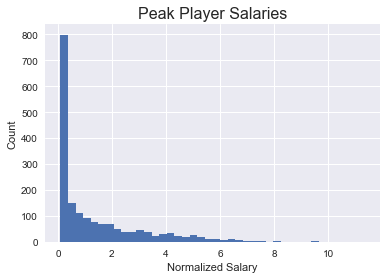

In [55]:
plt.hist(y_all3,bins = 40)
plt.title('Peak Player Salaries',size = 16)
plt.xlabel('Normalized Salary')
plt.ylabel('Count')

### LassoCV

In [56]:
std = StandardScaler()
#std.fit(X_train.values.astype(float))
std.fit(X_train3.iloc[:,1:])

X_tr3 = std.transform(X_train3.iloc[:,1:])
X_te3 = std.transform(X_test3.iloc[:,1:])

# Can use the same slicing of the data as before
alphavec = 10**np.linspace(-3,2,100)
lr_model4 = LassoCV(alphas = alphavec, cv=5)
lr_model4.fit(X_tr3,y_train3)
lr_model4.alpha_

list(zip(X_test3.columns[1:],lr_model4.coef_))

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[('AB', 0.5885777058476096),
 ('R', -0.73053446556062873),
 ('BA', 0.58422427329667548),
 ('H', -0.77758118394446596),
 ('SLG', 0.30336037510421515),
 ('OBP', -0.4054948129638643),
 ('HR', 0.10082904917750875),
 ('HR_rate', 0.17447369516201081),
 ('RBI', -0.27471826913339847),
 ('SB', 0.32645257345901146),
 ('BB_rate', 0.33665365746037651),
 ('SO_rate', -0.053581502102193555),
 ('IBB', 0.23645632184026233)]

In [57]:
lm_pred4 = lr_model4.predict(X_te3)
lr_model4.score(X_te3,y_test3)

0.38137821641772918

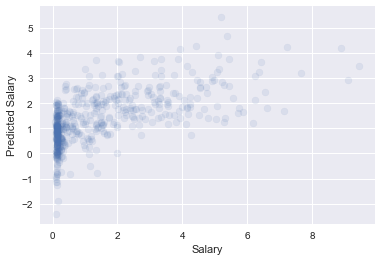

In [58]:
plt.scatter(y_test3,lm_pred4,alpha=0.1)
plt.xlabel('Salary')
plt.ylabel('Predicted Salary')

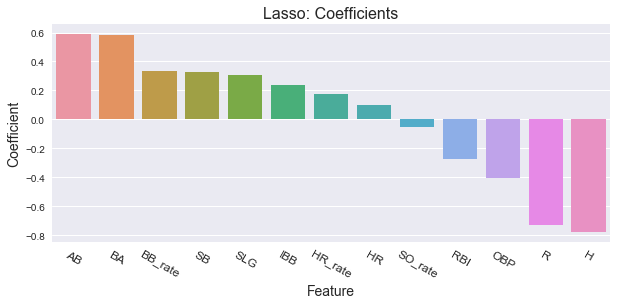

In [59]:
plt.figure(figsize=(10, 4))
lm4_importances = pd.Series(lr_model4.coef_, index=X_test3.columns[1:])
lm4_importances.sort_values(ascending=False,inplace=True)
g = sns.barplot(lm4_importances.index, lm4_importances);
g.set_xticklabels(lm4_importances.index, rotation=-30,size=12)
plt.ylabel('Coefficient',size=14);
plt.xlabel('Feature',size=14);
plt.title('Lasso: Coefficients',size = 16);

Counting stats are negatively correlated with peak salary projections. Rate based stas are positively correlated with projected peak salaries. This makes sense because the best minor leaguers don't hang around long enought to accumulated high counting stat numbers.

### Random Forest

In [60]:
rfmodel3 = ensemble.RandomForestRegressor(n_estimators = 1000, 
                                          min_samples_leaf= 6, 
                                          max_features=5,
                                          n_jobs=-1)
rfmodel3.fit(X_train3.iloc[:,1:],y_train3)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=6, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [61]:
rf3_test_pred = rfmodel3.predict(X_test3.iloc[:,1:])
print(rfmodel3.score(X_test3.iloc[:,1:],y_test3))
print(np.sqrt(np.mean((rf3_test_pred - y_test3)**2)))
list(zip(X_test3.columns[1:],rfmodel3.feature_importances_))

0.400428447058
1.33267805596


[('AB', 0.27254891090875799),
 ('R', 0.097208790653813298),
 ('BA', 0.074048813636035479),
 ('H', 0.15853818303029987),
 ('SLG', 0.094939269510026444),
 ('OBP', 0.041250610124917222),
 ('HR', 0.030311636691351118),
 ('HR_rate', 0.047818920462926011),
 ('RBI', 0.056047839642166732),
 ('SB', 0.036149154588064336),
 ('BB_rate', 0.024118973705174167),
 ('SO_rate', 0.027657866543124989),
 ('IBB', 0.039361030503342435)]

RF performing slighly better than Lasso methods, in terms of R2 and RMSE. However, RF as the advantage of not predicting impossible (i.e negative salaries).

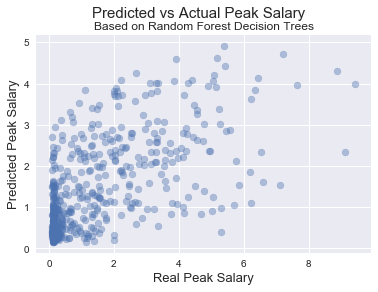

In [62]:
plt.scatter(y_test3,rf3_test_pred,alpha =0.4)

plt.xlabel('Real Peak Salary',size = 13)
plt.ylabel('Predicted Peak Salary',size = 13)
plt.suptitle('Predicted vs Actual Peak Salary',size =15)
plt.title('Based on Random Forest Decision Trees')
plt.show()

In [63]:
X_test3.columns[:-1]

Index(['player_id', 'AB', 'R', 'BA', 'H', 'SLG', 'OBP', 'HR', 'HR_rate', 'RBI',
       'SB', 'BB_rate', 'SO_rate'],
      dtype='object')

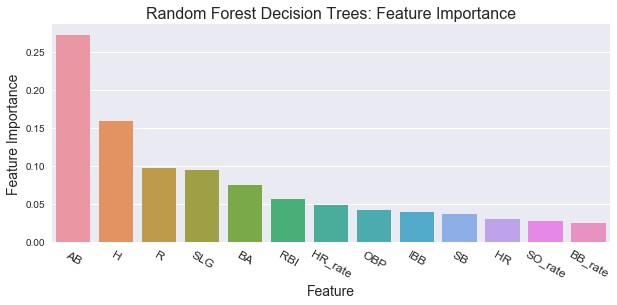

In [64]:
plt.figure(figsize=(10, 4))
rfmodel3_importances = pd.Series(rfmodel3.feature_importances_, index=X_test3.columns[1:])
rfmodel3_importances.sort_values(ascending=False,inplace=True)
g = sns.barplot(rfmodel3_importances.index, rfmodel3_importances);
g.set_xticklabels(rfmodel3_importances.index, rotation=-30,size=12)
plt.ylabel('Feature Importance',size=14);
plt.xlabel('Feature',size=14);
plt.title('Random Forest Decision Trees: Feature Importance',size = 16);

Once Again. There are some very good players need the top of the list, most of whom has very short minor league careers.

In [65]:
combo = copy.deepcopy(X_test3)
combo['salary_measured'] = y_test3
combo['salary_predicted'] = rf3_test_pred
combo.sort_values('salary_predicted',ascending = False).head(20)

,player_id,AB,R,BA,H,SLG,OBP,HR,HR_rate,RBI,SB,BB_rate,SO_rate,IBB,salary_measured,salary_predicted
536,dawsoan01,693.0,130.0,0.339,235.0,0.605,0.396,41.0,0.053,123.0,30.0,0.075,0.171,0.0,5.384,4.912
2118,teixema01,340.0,63.0,0.306,104.0,0.565,0.405,19.0,0.048,70.0,5.0,0.125,0.158,2.0,7.222,4.706
1571,olerujo01,10.0,2.0,0.300,3.0,0.600,0.417,1.0,0.083,2.0,0.0,0.167,0.083,0.0,5.177,4.628
2357,zimmery01,390.0,64.0,0.323,126.0,0.533,0.362,15.0,0.036,57.0,1.0,0.055,0.153,4.0,3.914,4.590
2078,strawda01,1455.0,302.0,0.289,421.0,0.568,0.407,97.0,0.055,330.0,97.0,0.160,0.217,24.0,5.427,4.435
216,bondsba01,402.0,79.0,0.303,122.0,0.540,0.403,20.0,0.041,74.0,31.0,0.145,0.172,0.0,8.883,4.292
593,drewst01,866.0,149.0,0.308,267.0,0.550,0.385,40.0,0.040,152.0,7.0,0.111,0.160,6.0,2.683,4.266
302,burrepa01,782.0,155.0,0.304,238.0,0.555,0.414,43.0,0.046,161.0,6.0,0.159,0.201,5.0,5.090,4.207
2133,thomafr04,631.0,123.0,0.306,193.0,0.506,0.447,24.0,0.030,116.0,8.0,0.195,0.147,2.0,6.437,4.144
188,biggicr01,497.0,119.0,0.344,171.0,0.517,0.436,12.0,0.020,90.0,50.0,0.134,0.122,1.0,4.408,4.093


In [66]:
#X_test3.iloc[indices]

parameters = {'subsample':np.arange(.6,.8,.1),
              'max_depth':[3,4,5],
              'learning_rate':[0.01],
              'n_estimators':[1000]}

gbmodel3 = ensemble.GradientBoostingRegressor()
grid_search3 = GridSearchCV(gbmodel3, parameters, n_jobs=-1, verbose=1)
grid_search3.fit(X_train3.iloc[:,1:],y_train3)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   17.8s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'subsample': array([ 0.6,  0.7,  0.8]), 'max_depth': [3, 4, 5], 'learning_rate': [0.01], 'n_estimators': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [67]:
grid_search3.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None,
             subsample=0.59999999999999998, verbose=0, warm_start=False)

In [68]:
grbst_test_pred3 = grid_search3.best_estimator_.predict(X_test3.iloc[:,1:])
print(grid_search3.best_estimator_.score(X_test3.iloc[:,1:],y_test3))
print(np.sqrt(np.mean((grbst_test_pred3  - y_test3)**2)))

0.380342164981
1.35481722524


Gradient Boosted Trees not performing as well as RF. I think this is because the sample sizes are too small.

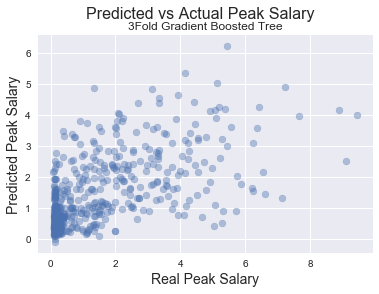

In [69]:
plt.scatter(y_test3,grbst_test_pred3,alpha = .4)

plt.xlabel('Real Peak Salary',size = 14)
plt.ylabel('Predicted Peak Salary',size = 14)
plt.suptitle('Predicted vs Actual Peak Salary',size =16)
plt.title('3Fold Gradient Boosted Tree')
plt.show()

In [70]:
mxr = mli.ModelXRay(rfmodel3,X_test3.iloc[:,1:],resolution=50)

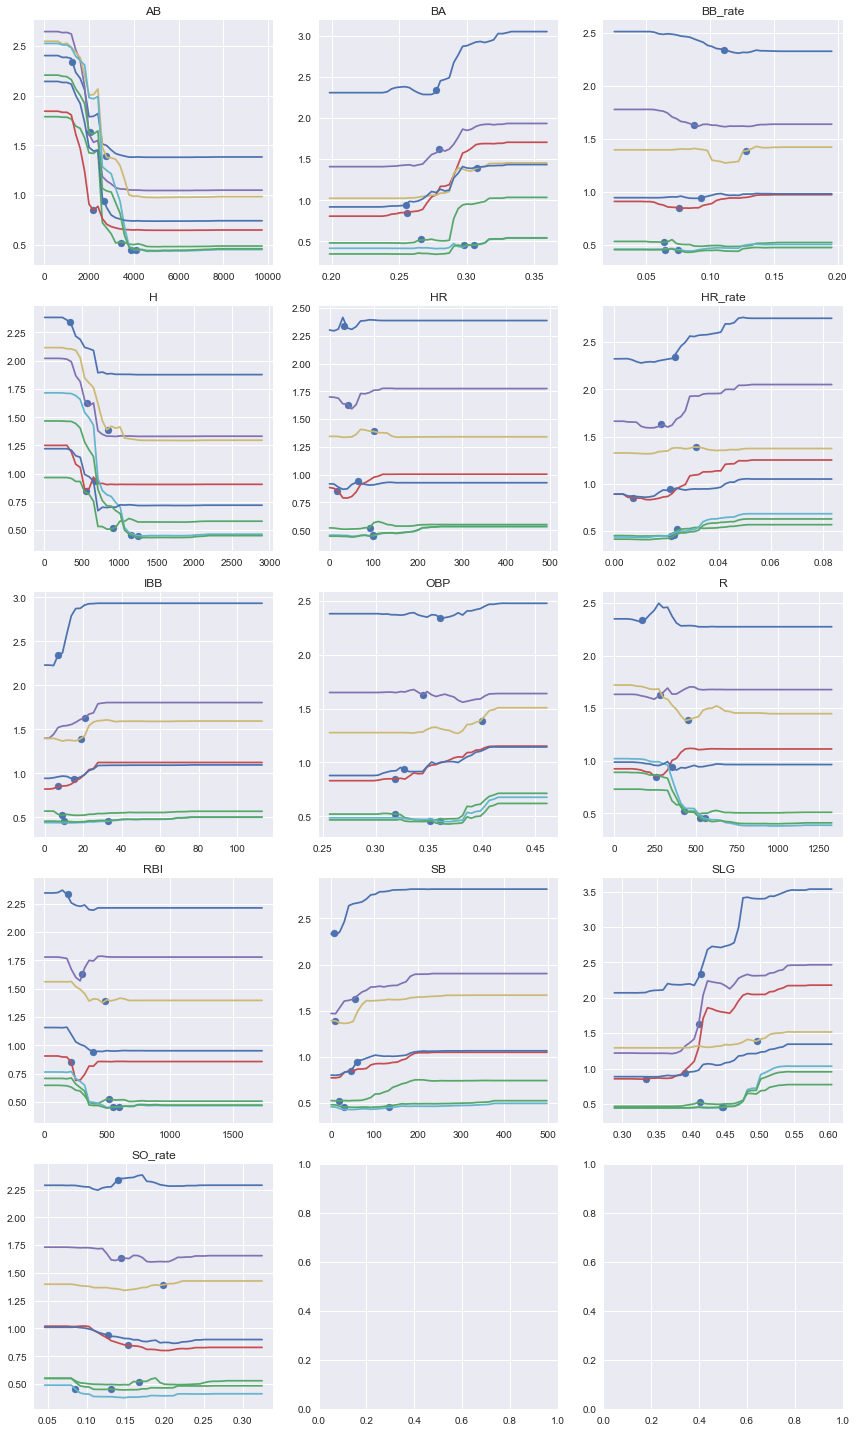

array([346,  64, 219, 175,  55, 399, 351, 259])

In [72]:
indices = mxr.feature_dependence_plots(num_pts=8)
plt.show()

indices